In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 20 14:13:56 2020

@author: Paula

Este archivo genera todos los gráficos y datos utilizados en el análisis de
datos de la tesis, tomando la información del archivo que devuelve
"LimpiezaDatos.py"

IMPORTANTE:
Para que el código funcione correctamente, el archivo .pkl que devuelve
"LimpiezaDatos.py" debe estar en el directorio donde se está trabajando.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
from scipy.stats import ttest_rel
from statsmodels.graphics.factorplots import interaction_plot

In [2]:
# %% Cargo el archivo que salió de LimpiezaDatos.py
data = pd.read_pickle("valid_subjects_data_PICKL.pkl")

In [3]:
# %% DEFINO FUNCIONES y PALETA DE COLORES
# Paleta Colorblind-friendly
cbPaleta = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2",
            "#D55E00", "#CC79A7", "#999999", "#E69F00", "#56B4E9", "#009E73",
            "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


def pos_estim(cond):
    '''
    Devuelve L o R dependiendo de si en la condición que está evaluando el
    estímulo está en izquierda o en derecha, respectivamente.
    Lo uso para tener la información para hacer el test de ANOVA.

    Parameters
    ----------
    cond: String con la condición a estudiar.

    Returns
    -------
    String L o R según corresponda.

    '''
    if cond == 'LL' or cond == 'LR':
        return 'L'
    else:
        return 'R'


def par_stimfdbk(cond):
    '''
    Devuelve "same" o "diff" ("mismo" o "diferente") dependiendo de si en la
    condición que está evaluando el estímulo y el feedback están ambos en el
    mismo oído o en diferentes.
    Lo uso para tener la información para hacer el test de ANOVA.

    Parameters
    ----------
    cond: String con la condición a estudiar.

    Returns
    -------
    String "same" o "diff" según corresponda.

    '''
    if cond == 'LL' or cond == 'RR':
        return 'same'
    else:
        return 'diff'

Text(0.5, 1.0, 'Asincronia en cada estimulo para el sujeto 1 en la condicion BB')

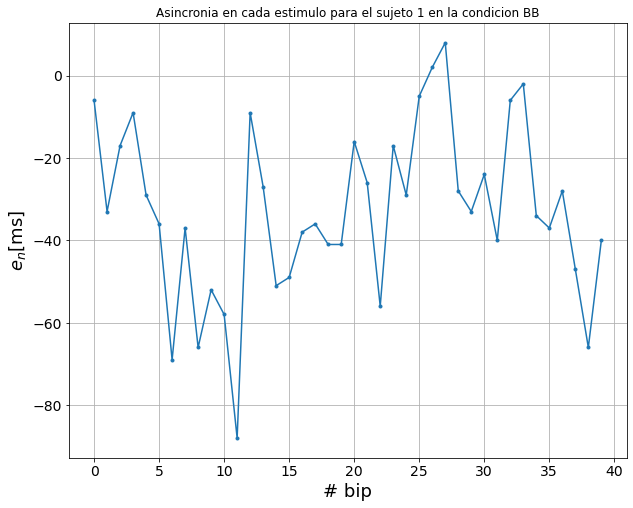

In [4]:
# %% Asincronía vs Nro de beep de un único trial

asynch = data['BB']['sujeto 1'].loc['trial11']

asynch.plot(use_index=False, style='.-', figsize=(10, 8))
plt.xlabel('# bip', fontsize=18)
plt.ylabel('$e_n$[ms]', fontsize=18)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Asincronia en cada estimulo para el sujeto 1 en la condicion BB')
# plt.savefig('SingleTrial_esquema.png')

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

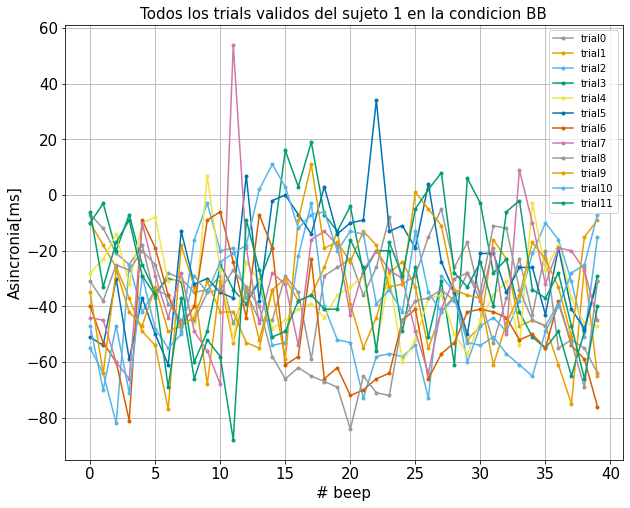

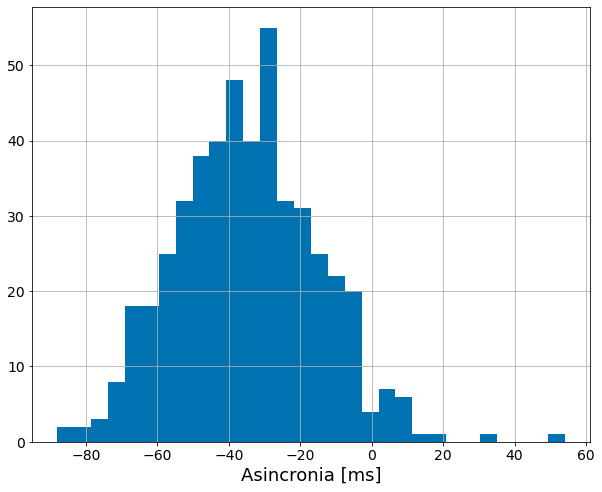

In [5]:
# %% Asincronía vs Nro de beep de todos los trials de un sujeto
subject = 'sujeto 1'
condition = 'BB'

# Es necesario trasponer el dataframe (.T) para que los beeps queden en
# el eje X
data[condition][subject].T.plot(use_index=False,
                                style='.-',
                                color=cbPaleta,
                                figsize=(10, 8))
plt.xlabel('# beep', fontsize=15)
plt.ylabel('Asincronia[ms]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.title('Todos los trials validos del %s en la condicion %s'
          % (subject, condition), fontsize=15)
# plt.savefig('Asynch_%s_%s_alltrials.png' % (subject, condition))


# AGREGO DISTRIBUCIÓN DE ASINCRONÍAS
plt.figure()
data['BB']['sujeto 1'].T.stack().plot.hist(bins=30,
                                           figsize=(10, 8),
                                           color=cbPaleta[5])
plt.grid()
plt.xlabel('Asincronia [ms]', fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('Distrib_Asynch_%s_%s.png' % (subject, condition))

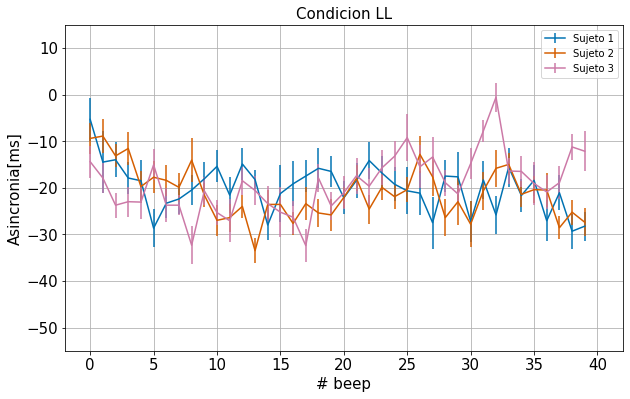

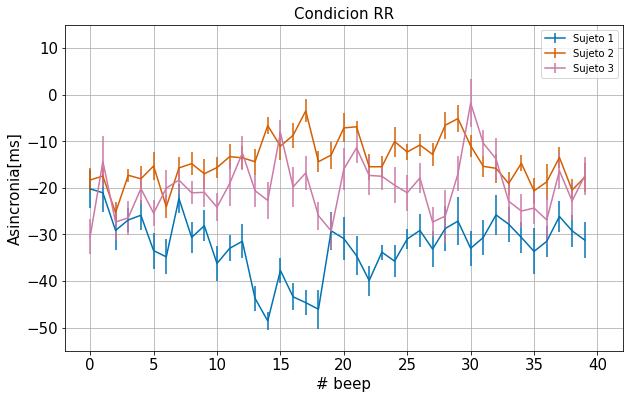

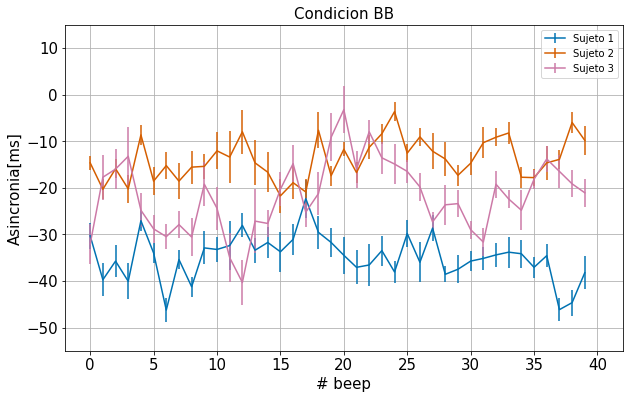

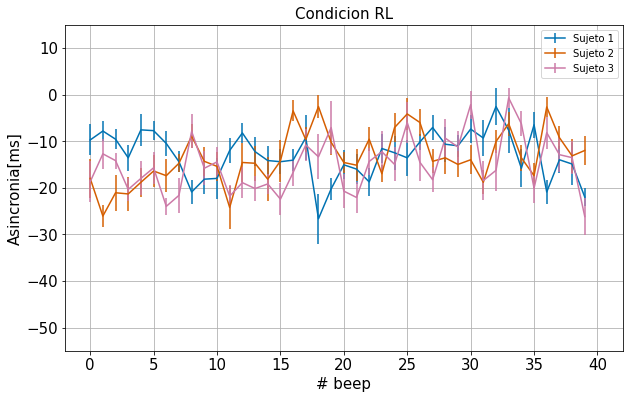

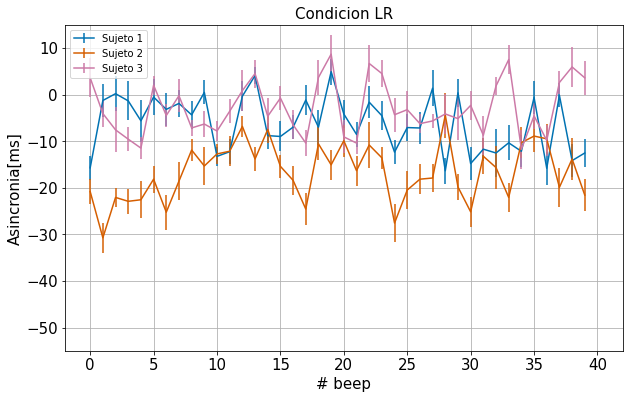

In [6]:
# %% Asincronía promedio por sujeto vs Nro de beep

condition_vector = ['LL', 'RR', 'BB', 'RL', 'LR']
total_number_subjects = len(data)

for condition in condition_vector:
    plt.figure(figsize=(10, 6))
    for subject in range(1, total_number_subjects+1):
        trial = data[condition]['sujeto %i' % subject]
        trial_promedio = trial.mean()
        trial_promedio_err = trial.std()/np.sqrt(len(trial_promedio))
        trial_promedio.plot(use_index=False,
                            label='Sujeto %i' % subject,
                            style='.-',
                            color=cbPaleta[subject+4],
                            yerr=trial_promedio_err)

    plt.axis([-2, 42, -55, 15])
    plt.xlabel('# beep', fontsize=15)
    plt.ylabel('Asincronia[ms]', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.title('Condicion %s' % condition, fontsize=15)

Text(0.5, 1.0, 'Promedio along y across trials para cada sujeto en cada condicion')

<Figure size 432x288 with 0 Axes>

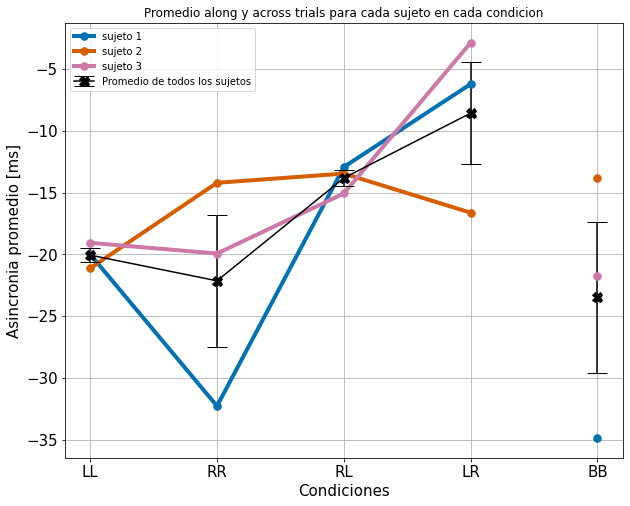

<Figure size 432x288 with 0 Axes>

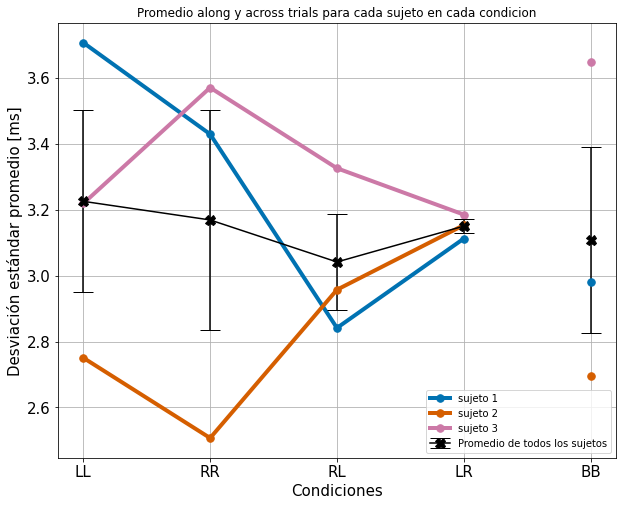

In [7]:
# %% Asincronía promedio (un valor por sujeto) vs condición

# Creo un DataFrame vacío para llenar con los valores promedio.
# Elijo hacerlo así y no directamente al plotear porque para calcular los
# promedios entre sujetos para cada condición, necesito volver a calcular todo
# nuevamente. Usando el dataframe, solo calculo las cosas una vez.
meandata = pd.DataFrame([],
                        columns=condition_vector,
                        index=['sujeto %i'
                               % i for i in range(1, total_number_subjects+1)])
# Relleno el DataFrame
for subject in range(1, total_number_subjects+1):
    for condition in condition_vector:
        trial = data[condition]['sujeto %i' % subject]
        meandata[condition]['sujeto %i' % subject] = trial.mean(axis=1).mean()

# Hago el plot (notar que el plot de BB está aparte porque así decidimos
# mostrar la información)
data_sinBB = meandata.loc[:, meandata.columns != 'BB']
plt.figure()
data_sinBB.T.plot(figsize=(10, 8),
                  style='.-',
                  linewidth=4,
                  markersize=15,
                  color=cbPaleta[5:])

# Agrego el promedio entre sujetos
data_sinBB.mean().plot(fmt='X-',
                       capsize=10,
                       markersize=10,
                       color='k',
                       label='Promedio de todos los sujetos',
                       yerr=data_sinBB.std()/np.sqrt(len(data_sinBB)))

# Para la parte de BB: uso un for porque quiero colores diferentes
# para cada punto (ya que cada punto representa un sujeto)
for i in range(total_number_subjects):
    plt.plot(4, meandata['BB'][i], '.', color=cbPaleta[i+5], markersize=15)

plt.errorbar(4, meandata['BB'].mean(),
             fmt='X-',
             capsize=10,
             markersize=10,
             color='k',
             yerr=meandata['BB'].std()/np.sqrt(len(meandata['BB'])))

# Burocracias y embellecimiento del gráfico
condition_x = [0, 1, 2, 3, 4]
condition_labels = ['LL', 'RR', 'RL', 'LR', 'BB']
plt.xticks(condition_x, condition_labels, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Asincronia promedio [ms]', fontsize=15)
plt.xlabel('Condiciones', fontsize=15)
plt.grid(True)
plt.legend()
plt.title('Promedio along y across trials para cada sujeto en cada condicion')
# plt.savefig('Mean_Unicovalor_xSubjxCond.png')

# Hago exactamente lo mismo pero ahora con los valores de std promedio
stddata = pd.DataFrame([],
                       columns=condition_vector,
                       index=['sujeto %i'
                              % i for i in range(1, total_number_subjects+1)])
# Relleno el DataFrame
for subject in range(1, total_number_subjects+1):
    for condition in condition_vector:
        trial = data[condition]['sujeto %i' % subject]
        stddata[condition]['sujeto %i' % subject] = (trial.std(axis=1) /
                                                     np.sqrt(len(trial.columns)
                                                             )).mean()

# Hago el plot (notar que el plot de BB está aparte porque así decidimos
# mostrar la información)
stddata_sinBB = stddata.loc[:, stddata.columns != 'BB']
plt.figure()
stddata_sinBB.T.plot(figsize=(10, 8),
                     style='.-',
                     linewidth=4,
                     markersize=15,
                     color=cbPaleta[5:])

# Agrego el promedio entre sujetos
stddata_sinBB.mean().plot(fmt='X-',
                          capsize=10,
                          markersize=10,
                          color='k',
                          label='Promedio de todos los sujetos',
                          yerr=stddata_sinBB.std()/np.sqrt(len(stddata_sinBB)))

# Para la parte de BB: uso un for porque quiero colores diferentes
# para cada punto (ya que cada punto representa un sujeto)
for i in range(total_number_subjects):
    plt.plot(4, stddata['BB'][i], '.', color=cbPaleta[i+5], markersize=15)

plt.errorbar(4, stddata['BB'].mean(),
             fmt='X-',
             capsize=10,
             markersize=10,
             color='k',
             yerr=stddata['BB'].std()/np.sqrt(len(stddata['BB'])))

# Burocracias y embellecimiento del gráfico
condition_x = [0, 1, 2, 3, 4]
condition_labels = ['LL', 'RR', 'RL', 'LR', 'BB']
plt.xticks(condition_x, condition_labels, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Desviación estándar promedio [ms]', fontsize=15)
plt.xlabel('Condiciones', fontsize=15)
plt.grid(True)
plt.legend()
plt.title('Promedio along y across trials para cada sujeto en cada condicion')
# plt.savefig('Std_Unicovalor_xSubjxCond.png')

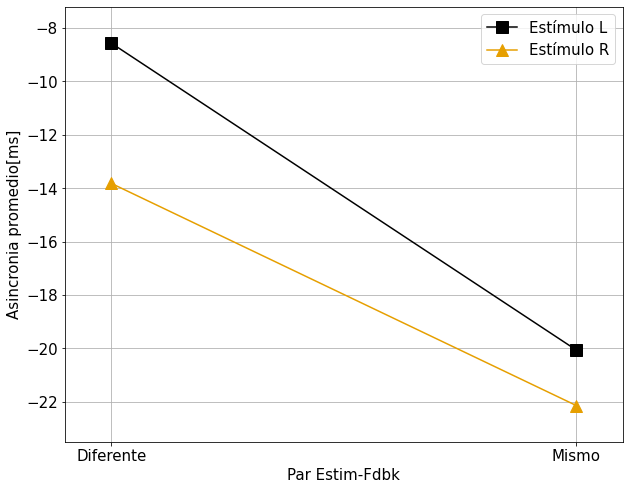

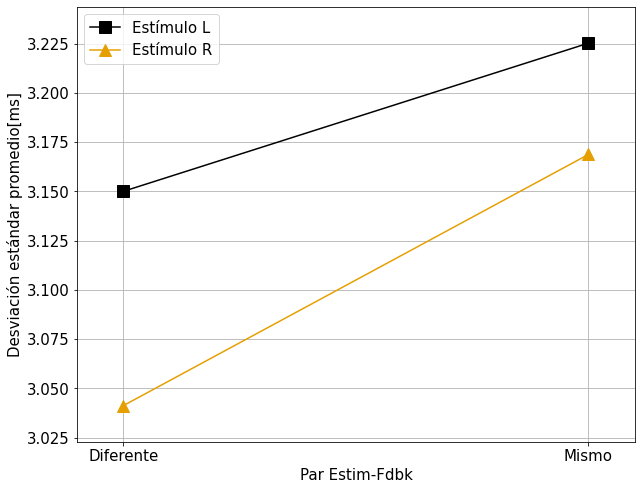

In [8]:
# %% Test de hipótesis: two way ANOVA repeated measures. Trabajo con los
# valores promedio de asincronía.

# Primero necesito reacomodar el DataFrame para tener todo como columnas y
# poder dárselo a la funcion de repeated measures de ANOVA.
data_anova = pd.melt(meandata.loc[:, meandata.columns != 'BB'].reset_index(),
                     id_vars='index',
                     var_name=['condition'])

# Agrego una columna con la información del factor "Par estim-fdbk"
data_anova['par_sf'] = data_anova.apply(lambda row:
                                        par_stimfdbk(row.condition),
                                        axis=1)
# Agrego una columan con la información del factor "Posicion del estímulo"
data_anova['pos_estim'] = data_anova.apply(lambda row:
                                           pos_estim(row.condition),
                                           axis=1)
# Transformo los valores a tipo numérico (para que pueda recibirla la función
# de pingouin)
data_anova['value'] = pd.to_numeric(data_anova['value'])

# Hago el test de ANOVA de dos factores y medidas repetidas.
# Lo que nos interesa de tabla_anova es 'F' y 'p-unc'.
tabla_anova = pg.rm_anova(dv='value',
                          within=['par_sf', 'pos_estim'],
                          subject='index',
                          data=data_anova)

# Plot de interacción entre factores.
fig, ax = plt.subplots(figsize=(10, 8))

interaction_plot(x=data_anova['par_sf'],
                 trace=data_anova['pos_estim'],
                 response=data_anova['value'],
                 ax=ax,
                 colors=['k', cbPaleta[1]], markers=['s', '^'], ms=12)

plt.xlabel('Par Estim-Fdbk', fontsize=15)
plt.ylabel('Asincronia promedio[ms]', fontsize=15)
labels = ['Diferente', 'Mismo']
plt.xticks([0, 1], labels, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend(['Estímulo L', 'Estímulo R'], fontsize=15)
# plt.savefig('Interactionplot_MEAN.png')


# Hago exactamente lo mismo para la desviación estándar
data_anovastd = pd.melt(stddata.loc[:, stddata.columns != 'BB'].reset_index(),
                        id_vars='index',
                        var_name=['condition'])

# Agrego una columna con la información del factor "Par estim-fdbk"
data_anovastd['par_sf'] = data_anovastd.apply(lambda row:
                                              par_stimfdbk(row.condition),
                                              axis=1)
# Agrego una columan con la información del factor "Posicion del estímulo"
data_anovastd['pos_estim'] = data_anovastd.apply(lambda row:
                                                 pos_estim(row.condition),
                                                 axis=1)
# Transformo los valores a tipo numérico (para que pueda recibirla la función
# de pingouin)
data_anovastd['value'] = pd.to_numeric(data_anovastd['value'])

# Hago el test de ANOVA de dos factores y medidas repetidas.
# Lo que nos interesa de tabla_anova es 'F' y 'p-unc'.
tabla_anovastd = pg.rm_anova(dv='value',
                             within=['par_sf', 'pos_estim'],
                             subject='index',
                             data=data_anovastd)

# Plot de interacción entre factores.
fig, ax1 = plt.subplots(figsize=(10, 8))

interaction_plot(x=data_anovastd['par_sf'],
                 trace=data_anovastd['pos_estim'],
                 response=data_anovastd['value'],
                 ax=ax1,
                 colors=['k', cbPaleta[1]], markers=['s', '^'], ms=12)

plt.xlabel('Par Estim-Fdbk', fontsize=15)
plt.ylabel('Desviación estándar promedio[ms]', fontsize=15)
labels = ['Diferente', 'Mismo']
plt.xticks([0, 1], labels, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend(['Estímulo L', 'Estímulo R'], fontsize=15)
# plt.savefig('Interactionplot_STD.png')

In [9]:
# %% Test de Student pareado entre (BB,RR) y (BB,LL).

# Defino alpha
alpha = 0.05/2

# Comparo BB con LL en los valores de asincronía promedio
statBBLL, pBBLL = ttest_rel(meandata['BB'], meandata['LL'])
print('Statistics=%.3f, p=%.3f' % (statBBLL, pBBLL))

if pBBLL > alpha:
    print('Accept null hypothesis that the means between BB and LL are equal.')
else:
    print('Reject null hypothesis that the means between BB and LL are equal.')

# Comparo BB con RR en los valores de asincronía promedio
statBBRR, pBBRR = ttest_rel(meandata['BB'], meandata['RR'])
print('Statistics=%.3f, p=%.3f' % (statBBRR, pBBRR))

if pBBRR > alpha:
    print('Accept null hypothesis that the means between BB and RR are equal.')
else:
    print('Reject null hypothesis that the means between BB and RR are equal.')


# Lo mismo pero con la desviación estándar
# Comparo BB con LL en desviación estándar promedio
stdBBLL, stdpBBLL = ttest_rel(stddata['BB'], stddata['LL'])
print('Statistics=%.3f, p=%.3f' % (stdBBLL, stdpBBLL))

if stdpBBLL > alpha:
    print('Accept null hypothesis that the means between BB and LL'
          + ' (STD) are equal.')
else:
    print('Reject null hypothesis that the means between BB and LL'
          + ' - STD are equal.')

# Comparo BB con LL en desviación estándar promedio
stdBBRR, stdpBBRR = ttest_rel(stddata['BB'], stddata['RR'])
print('Statistics=%.3f, p=%.3f' % (stdBBRR, stdpBBRR))

if stdpBBRR > alpha:
    print('Accept null hypothesis that the means between BB and RR'
          + '(STD) are equal.')
else:
    print('Reject null hypothesis that the means between BB and RR'
          + '(STD) are equal.')

Statistics=-0.534, p=0.647
Accept null hypothesis that the means between BB and LL are equal.
Statistics=-1.531, p=0.266
Accept null hypothesis that the means between BB and RR are equal.
Statistics=-0.351, p=0.759
Accept null hypothesis that the means between BB and LL (STD) are equal.
Statistics=-0.311, p=0.785
Accept null hypothesis that the means between BB and RR(STD) are equal.
